In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import pandas as pd

print(tf.__version__)

2.0.0-rc0


In [41]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

True

In [3]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence_english(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w
  
def preprocess_sentence_hindi(w):
    w = unicode_to_ascii(w.strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
#     w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [4]:
PATH = "Hindi_English_Truncated_Corpus.csv"
data = pd.read_csv(PATH)
data.head(3)

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।


In [5]:
print(data['english_sentence'].count())
print(data['hindi_sentence'].count())

127605
127607


In [6]:
data = data[data['english_sentence'].map(type) == str]
data = data[data['hindi_sentence'].map(type) == str]
data = data[data['english_sentence'].map(len) > 0]
data = data[data['hindi_sentence'].map(len) > 0]

print(data['english_sentence'].count())
print(data['hindi_sentence'].count())

127605
127605


In [7]:
data["token_size_en"] = data["english_sentence"].apply(lambda x: len(x.split(' ')))
data["token_size_hn"] = data["hindi_sentence"].apply(lambda x: len(x.split(' ')))


In [8]:
data = data.loc[data['token_size_hn'] < 22].copy()

In [9]:
int(data['english_sentence'].count())
print(data['hindi_sentence'].count())

90799


In [10]:
# def encode_str(string):
#   return string.encode('UTF-8', 'ignore')

In [11]:
# data['english_sentence'] = data['english_sentence'].apply(encode_str)
# data['hindi_sentence'] = data['hindi_sentence'].apply(encode_str)

In [12]:
data['english_sentence'] = data['english_sentence'].apply(preprocess_sentence_english)
data['hindi_sentence'] = data['hindi_sentence'].apply(preprocess_sentence_hindi)

In [13]:
data.head()

,source,english_sentence,hindi_sentence,token_size_en,token_size_hn
0,ted,<start> politicians do not have permission to ...,"<start> राजनीतिजञो क पास जो कारय करना चाहिए , ...",12,14
1,ted,<start> i d like to tell you about one such ch...,<start> मई आपको ऐस ही एक बचच क बार म बताना चाह...,9,11
2,indic2012,<start> this percentage is even greater than t...,<start> यह परतिशत भारत म हिनदओ परतिशत स अधिक ह...,10,9
3,ted,<start> what we really mean is that they re ba...,<start> हम य नही कहना चाहत कि वो धयान नही द पा...,12,11
4,indic2012,<start> . the ending portion of these vedas is...,<start> इनही वदो का अतिम भाग उपनिषद कहलाता ह। ...,9,8


In [14]:
en = data['english_sentence'].values.tolist()
hn = data['hindi_sentence'].values.tolist()

In [15]:
len(en),len(hn)

(90799, 90799)

In [16]:
en[-1],hn[-1]

('<start> they ve just won four government contracts to build off their ambulances , <end>',
 '<start> हाल ही म उनह सरकारी ठका मिला ह करीब सौ नई अमबलनस बनान का , <end>')

In [17]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [18]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [19]:
def load_dataset(num_examples):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = data['hindi_sentence'].values.tolist()[:num_examples],data['english_sentence'].values.tolist()[:num_examples]

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [20]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(35000)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)


In [21]:
print(max_length_inp,max_length_targ)
print(len(input_tensor),target_tensor[:2])

48 31
35000 [[   1 7745    4  109   29  197   92  106    7   52   36   16 1806   19
     3    5    2    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   1 1404  112  176   23   14  217    4   51    6 1129 2600    7    2
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]]


In [22]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

28000 28000 7000 7000


In [23]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [24]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
9 ----> in
25 ----> he
132 ----> got
4 ----> the
6555 ----> filmfare
872 ----> award
20 ----> for
4 ----> the
266 ----> best
2709 ----> actor
20 ----> for
4 ----> the
462 ----> role
6 ----> of
3741 ----> amar
184 ----> akbar
3742 ----> anthony
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
6727 ----> १९७७
6 ----> म
1096 ----> इनहोन
2710 ----> अमर
219 ----> अकबर
8263 ----> एनथनी
6 ----> म
37 ----> अपन
1602 ----> परदरशन
4 ----> क
24 ----> लिए
2167 ----> सरवशरषठ
3395 ----> अभिनता
11 ----> का
4972 ----> फिलमफयर
545 ----> परसकार
6728 ----> जीता।
2 ----> <end>


In [25]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [26]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 48]), TensorShape([64, 31]))

In [27]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [28]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 48, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [29]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [30]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 48, 1)


In [31]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [32]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 27722)


In [33]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [38]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [109]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [110]:
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.6609
Epoch 1 Batch 100 Loss 2.5505
Epoch 1 Batch 200 Loss 2.5381
Epoch 1 Batch 300 Loss 2.4214
Epoch 1 Batch 400 Loss 2.2936
Epoch 1 Loss 2.5496
Time taken for 1 epoch 334.2392861843109 sec

Epoch 2 Batch 0 Loss 2.1911
Epoch 2 Batch 100 Loss 2.2041
Epoch 2 Batch 200 Loss 2.0321
Epoch 2 Batch 300 Loss 2.5544
Epoch 2 Batch 400 Loss 2.0181
Epoch 2 Loss 2.2074
Time taken for 1 epoch 315.29234886169434 sec

Epoch 3 Batch 0 Loss 1.8320
Epoch 3 Batch 100 Loss 2.2029
Epoch 3 Batch 200 Loss 2.0372
Epoch 3 Batch 300 Loss 2.2875
Epoch 3 Batch 400 Loss 2.1488
Epoch 3 Loss 1.9763
Time taken for 1 epoch 305.95008659362793 sec

Epoch 4 Batch 0 Loss 1.7214
Epoch 4 Batch 100 Loss 1.9824
Epoch 4 Batch 200 Loss 1.9184
Epoch 4 Batch 300 Loss 1.6821
Epoch 4 Batch 400 Loss 1.9371
Epoch 4 Loss 1.7396
Time taken for 1 epoch 316.46778750419617 sec

Epoch 5 Batch 0 Loss 1.5124
Epoch 5 Batch 100 Loss 1.6091
Epoch 5 Batch 200 Loss 1.4146
Epoch 5 Batch 300 Loss 1.4384
Epoch 5 Batch 400 Loss 

In [34]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence_english(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [35]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [36]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [39]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> home <end>
Predicted translation: घर <end> 


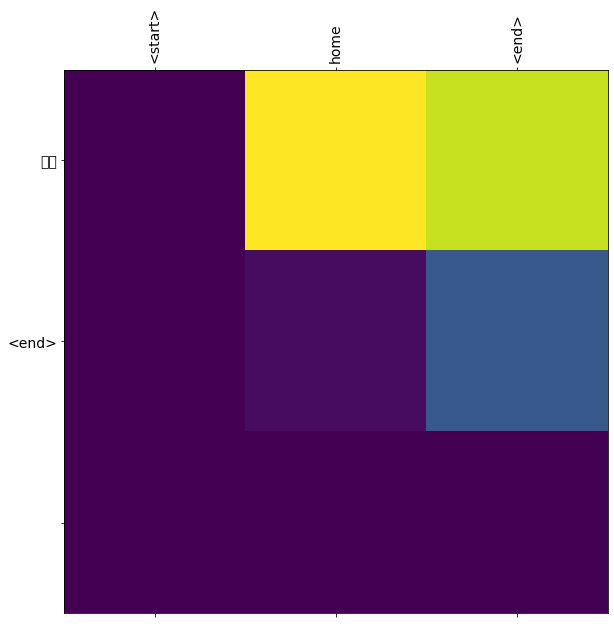

In [50]:
translate('home')

Input: <start> work <end>
Predicted translation: कारय <end> 


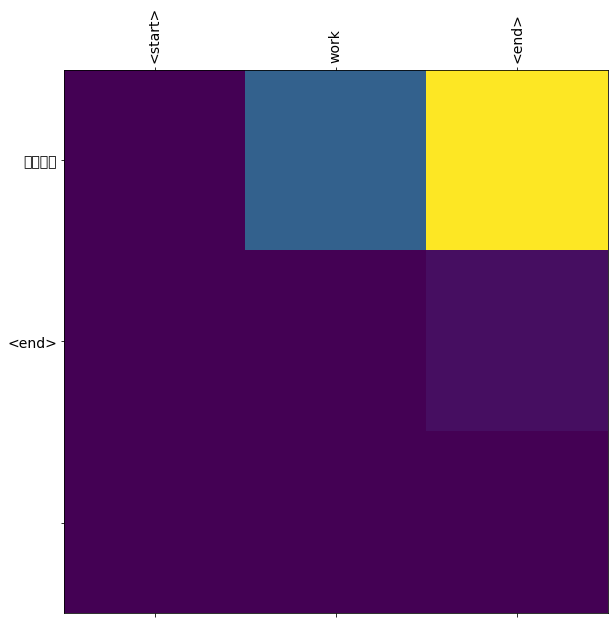

In [55]:
translate(' work')